<a href="https://colab.research.google.com/github/SanjaySaatyaki/nlp_with_hf/blob/main/2_txt_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets

In [2]:
from datasets import load_dataset

In [3]:
emotions = load_dataset("emotion")
emotions

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
!pwd

/content


In [5]:
train_ds  = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

In [9]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [10]:
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [13]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


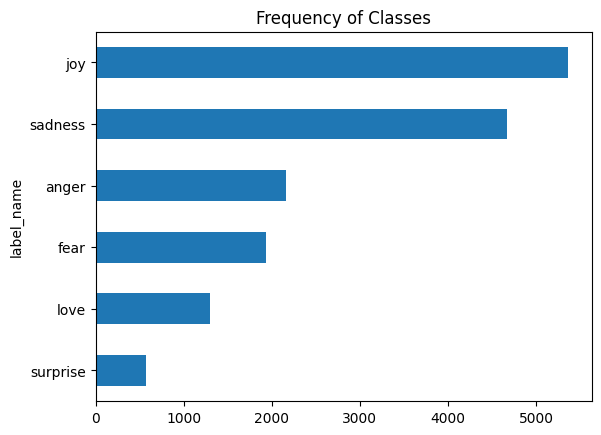

In [14]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

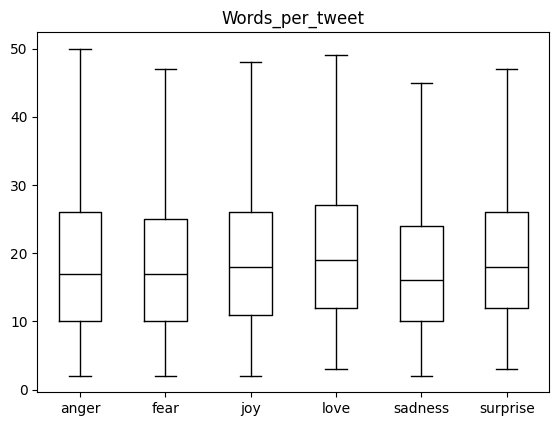

In [15]:
df["Words_per_tweet"] = df["text"].str.split().apply(len)

df.boxplot("Words_per_tweet", by="label_name", grid=False,showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [16]:
emotions.reset_format()

In [17]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
text= "Tokenizing text is a core task of NLP"
encoded_text = tokenizer(text)

In [19]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [20]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [21]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Transformers as Feature Extrators

In [22]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [23]:
text = "this is a test sentence"
inputs = tokenizer(text, return_tensors="pt")
print(f"Inputs: {inputs['input_ids'].size()}")

Inputs: torch.Size([1, 7])


In [24]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2189, -0.1915, -0.0067,  ..., -0.0973,  0.0517,  0.4798],
         [-0.5847, -0.5740, -0.1525,  ..., -0.2300,  0.3013,  0.4379],
         [-0.4721, -0.3686,  0.0454,  ..., -0.0966, -0.0936,  0.9945],
         ...,
         [ 0.3245, -0.3735, -0.0680,  ..., -0.5482,  0.0609, -0.3396],
         [ 0.0457, -0.2219, -0.2684,  ..., -0.1045, -0.0945, -0.2372],
         [ 0.9335,  0.0091, -0.4542,  ...,  0.1790, -0.8192, -0.1947]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [25]:
outputs.last_hidden_state.size()

torch.Size([1, 7, 768])

In [30]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}


In [31]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [32]:
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask","label"])

In [33]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [36]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2,metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_,columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.378525,3.277581,0
1,-2.866815,3.980570,0
2,5.255753,6.641500,3
3,-2.496874,6.265224,2
4,-3.287658,5.989703,3


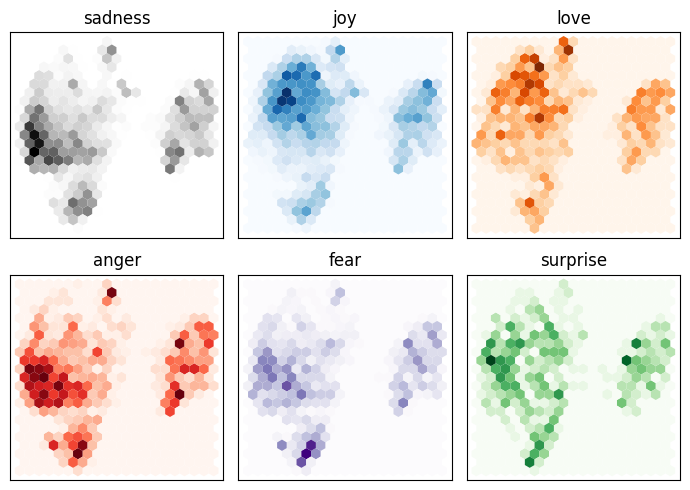

In [40]:
fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys","Blues","Oranges","Reds","Purples","Greens"]
labels = emotions["train"].features["label"].names

for i,(label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [41]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)


0.634

In [42]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

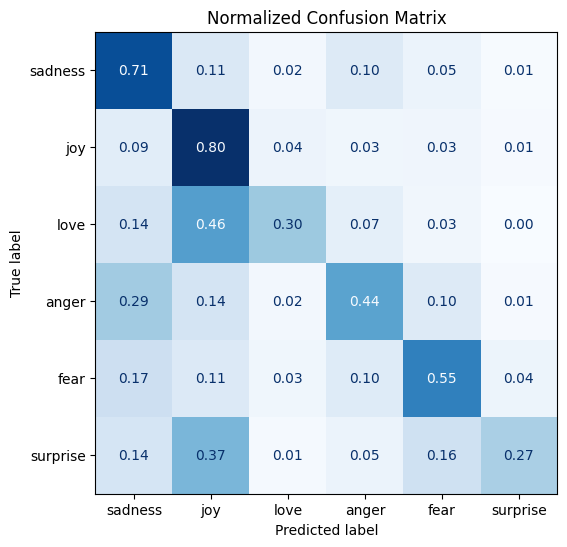

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues",values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

#Finetuning Transformers

In [45]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1":f1}

In [52]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir = model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay=0.01,
    eval_strategy = "epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [55]:
from transformers import Trainer

trainer = Trainer(model=model, args= training_args,
                  compute_metrics=compute_metrics,
                  train_dataset= emotions_encoded["train"],
                  eval_dataset= emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/tmp/ipython-input-232085581.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args= training_args,
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.865600,0.341217,0.905000,0.904304
2,0.266500,0.230243,0.922500,0.922363


TrainOutput(global_step=500, training_loss=0.5660381317138672, metrics={'train_runtime': 309.548, 'train_samples_per_second': 103.377, 'train_steps_per_second': 1.615, 'total_flos': 720342861696000.0, 'train_loss': 0.5660381317138672, 'epoch': 2.0})

#Error Analysis

In [56]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

  return {"loss":loss.cpu().numpy(),
          "predicted_label":pred_label.cpu().numpy()}

In [57]:
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])

emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [58]:
emotions_encoded.set_format("pandas")
cols = ["text","label","predicted_label","loss"]
df_test= emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [59]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.592159
882,i feel badly about reneging on my commitment t...,love,sadness,5.530186
1963,i called myself pro life and voted for perry w...,joy,sadness,5.230877
1950,i as representative of everything thats wrong ...,surprise,anger,5.034151
405,i have been feeling extraordinarily indecisive...,fear,joy,4.946054
1509,i guess this is a memoir so it feels like that...,joy,fear,4.909851
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.828204
1274,i am going to several holiday parties and i ca...,joy,sadness,4.788174
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.779274
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.541485
